## This script fits simple cross validated SVM using single fit and alpy

## It should be straightforward to go from this script to running experiments on any fingerprint/compound pair

In [100]:
% load_ext autoreload
% autoreload 2
import matplotlib.pylab as plt
% matplotlib inline
import sys
import seaborn
sys.path.insert(0, "../mlls2015")
sys.path.insert(0, "..")
import training_data
from models.cv import AdaptiveGridSearchCV
from training_data.datasets import CVBaseChemDataset
import bunch
import numpy as np
from bunch import Bunch
import os
import logging
from experiments.utils import wac_score
from misc.utils import config_log_to_file

import copy
from models.balanced_models import *

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import alpy
import alpy_addons
from alpy_addons.active import ActiveLearner
from alpy.datasets.generate import get_2d_gaussians
from alpy_addons.monitors import *
from alpy.oracle import SimulatedOracle
from six import iteritems

from alpy_addons.strategy import UncertaintySampling, PassiveStrategy
from alpy.utils import mask_unknowns

from sklearn.metrics import auc

from training_data.datasets import calculate_jaccard_kernel

from sklearn.grid_search import GridSearchCV

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
opts = Bunch({"C_min": -6, 
              "C_max": 5,
              "internal_cv": 4,
              "max_iter": 10000000,
              "n_folds": 5, 
              "preprocess": "clip01", #"max_abs", 
              "fold": 3, 
              "d": 1,
              "warm_start": 20, # TODO: add cluster-dependent warm_start
              "strategy_kwargs": "",
              "strategy": "UncertaintySampling",
              "compound": "5-HT1a", 
              "representation": "MACCS", 
              "jaccard": 1, 
              "rng": 777, 
              "name": "test_svm_al",
              "batch_size": 50,
              "output_dir": "/Users/kudkudak/code/mlls2015/"})

In [102]:
# TODO: try to underfit

In [103]:
config_log_to_file(os.path.join(opts.output_dir, opts.name + ".log"), clear_log_file=True)
logger = logging.getLogger("fit_svm")
logger.info(opts.__dict__)
logger.info(opts.name)

INFO:fit_svm:{}
INFO:fit_svm:test_svm_al


In [104]:
data = CVBaseChemDataset(compound=opts.compound, representation=opts.representation, n_folds=opts.n_folds, rng=opts.rng,
                       preprocess=opts.preprocess)
(X_train, y_train), (X_valid, y_valid) = data.get_data(fold=opts.fold)
if opts.jaccard:
    X_train, X_valid = calculate_jaccard_kernel(data=data, fold=opts.fold)
    
X_train = X_train
y_train = y_train

In [105]:
y_train_masked = mask_unknowns(y_train, 
                               np.random.choice(X_train.shape[0], 
                                                size=X_train.shape[0] - opts.warm_start, replace=False))

In [106]:
def wac_scoring(estimator, X, y):
    return wac_score(y, estimator.predict(X))

In [107]:
kernel = "precomputed" if opts.jaccard else "linear"

if opts.d <= 0:
    estimator = GridSearchCV(
                           estimator=SVC(random_state=opts.rng, kernel=kernel, max_iter=opts.max_iter), 
                           param_grid = 
                               {
                                 "C": [10**c for c in range(opts.C_min, opts.C_max + 1)]}, 
                           cv=opts.internal_cv, 
                           scoring=wac_scoring, 
                           error_score=0.)
else:
    estimator = AdaptiveGridSearchCV(d=opts.d, 
                           estimator=SVC(random_state=opts.rng, kernel=kernel, max_iter=opts.max_iter), 
                           param_grid = 
                               {
                                 "C": [10**c for c in range(opts.C_min, opts.C_max + 1)]}, 
                           cv=opts.internal_cv, 
                           scoring=wac_scoring, 
                           error_score=0.)

In [108]:
StrategyCls = getattr(alpy_addons.strategy, opts.strategy, getattr(alpy.strategy, opts.strategy, None))
if not StrategyCls:
    raise RuntimeError("Not found strategy " + opts.strategy)
strategy_kwargs = {token.split()[0]: float(token.split()[1]) for token in opts.strategy_kwargs.split()}
logger.info("Parsed strategy kwargs: " + str(strategy_kwargs))
strategy = StrategyCls(**strategy_kwargs)

INFO:fit_svm:Parsed strategy kwargs: {}


In [109]:
al = ActiveLearner(strategy=strategy,
                             random_state=opts.rng,
                             batch_size=opts.batch_size,
                             oracle=SimulatedOracle(sample_budget=np.inf),
                             estimator=estimator)

In [ ]:
# TODO: add cluster monitors

monitors = []

monitors.append(ExtendedMetricMonitor(name="wac_score",
                        short_name="wac_score",
                        function=wac_score,
                        ids="all",
                        frequency=1))


monitors.append(ExtendedMetricMonitor(name="wac_score_labeled",
                        short_name="wac_score_labeled",
                        function=wac_score,
                        ids="known",
                        frequency=1))

monitors.append(ExtendedMetricMonitor(name="wac_score_unlabeled",
                        short_name="wac_score_unlabeled",
                        function=wac_score,
                        ids="unknown",
                        frequency=1))

monitors.append(ExtendedMetricMonitor(name="wac_score_valid",
                        short_name="wac_score_valid",
                        function=wac_score,
                        frequency=1,
                        X=X_valid,
                        y=y_valid))

monitors.append(SimpleLogger(batch_size=opts.batch_size))

monitors.append(EstimatorMonitor(only_params=True))

monitors.append(GridScoresMonitor())

In [ ]:
al.fit(X_train, y_train_masked, monitors=monitors)

INFO:alpy_addons.monitors:iter 0
INFO:alpy_addons.monitors:iter 50
INFO:alpy_addons.monitors:iter 100
INFO:alpy_addons.monitors:iter 150
INFO:alpy_addons.monitors:iter 200
INFO:alpy_addons.monitors:iter 250
INFO:alpy_addons.monitors:iter 300
INFO:alpy_addons.monitors:iter 350
INFO:alpy_addons.monitors:iter 400
INFO:alpy_addons.monitors:iter 450
INFO:alpy_addons.monitors:iter 500
INFO:alpy_addons.monitors:iter 550
INFO:alpy_addons.monitors:iter 600
INFO:alpy_addons.monitors:iter 650
INFO:alpy_addons.monitors:iter 700
INFO:alpy_addons.monitors:iter 750
INFO:alpy_addons.monitors:iter 800
INFO:alpy_addons.monitors:iter 850
INFO:alpy_addons.monitors:iter 900
INFO:alpy_addons.monitors:iter 950
INFO:alpy_addons.monitors:iter 1000
INFO:alpy_addons.monitors:iter 1050
INFO:alpy_addons.monitors:iter 1100
INFO:alpy_addons.monitors:iter 1150
INFO:alpy_addons.monitors:iter 1200
INFO:alpy_addons.monitors:iter 1250
INFO:alpy_addons.monitors:iter 1300
INFO:alpy_addons.monitors:iter 1350
INFO:alpy_addon

In [15]:
def plot(m):
    ### Plot model accuracy
    plt.clf()
    unc_wac = m['wac_score_labeled']
    unc_wac_unlabeled = m['wac_score_unlabeled']
    unc_wac_valid = m['wac_score_valid']

    t = np.arange(len(unc_wac)) * opts.batch_size
    p1 = plt.plot(t, unc_wac, 'r')
    p2 = plt.plot(t, unc_wac_valid, 'g')
    p3 = plt.plot(t, unc_wac_unlabeled, 'b')
    plt.legend((p1[0], p2[0], p3[0]), ('WAC_labeled', 'WAC valid', 'WAC not seen'), loc='best')
    plt.title('Models Accuracy')
    plt.show()

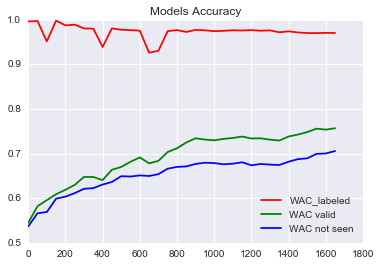

In [44]:
plot(monitor_outputs_cv_j_u)

In [ ]:
def generate_time_report(monitor_outputs):
    # Returns dict with percentage/amount of time spent in each section (all keys with "_time" suffix)
    report = {}
    total_time = float(sum(monitor_outputs['iter_time']))
    for k in monitor_outputs:
        if k.endswith("_time"):
            report[k] = [sum(monitor_outputs[k]), sum(monitor_outputs[k]) / total_time]
    return report

In [ ]:
def calculate_scores(monitor_outputs):
    scores = {}
    for k in monitor_outputs:
        if "score" in k:
            scores[k + "_mean"] = np.mean(monitor_outputs[k])
            scores[k + "_auc"] = auc(np.arange(len(monitor_outputs[k])), monitor_outputs[k])
    return scores

In [ ]:
json_results = dict(best_results)
json_results['cmd'] = "{} {}".format(__file__, " ".join("--{} {}".format(k, v) for k, v in iteritems(opts.__dict__)))
json_results['opts'] = opts.__dict__
json_results['dataset'] = data.get_params()
json_results['time_reports'] = generate_time_report(al.monitor_outputs_)
json_results['scores'] = calculate_scores(al.monitor_outputs_)
del json_results['y_pred']

json.dump(json_results, open(path.join(output_dir, name + ".json"), "w"), indent=4, sort_keys=True)
cPickle.dump(al.monitor_outputs_, gzip.open(path.join(output_dir, name + ".pkl.gz"), "w"))

In [ ]:
# TODO: write test that will:
# - check repeatibility of whole AL experiment
# - check that final accuracy is SAME as fitting just single estimator
# - check that we have a classifier that doesn't overfit!
# - sanity checks for results:
    # * CV not picked on the borders in more than 5% of cases
    # * performance is lower than 98% on labeled in 50% of time